In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
#%matplotlib notebook
%matplotlib inline

In [6]:
# delta robot param
# https://www.academia.edu/27264858/Delta_Kin
# https://journals.sagepub.com/doi/pdf/10.5772/61744

Rb = 1.0    # base radius
Rm = 0.2    # mobile platfrom radius

Lr = 5.0    # prismatic joint length
Le = 1.5    # link lengt

"""
             A1                      
            /|\                 
           / | \
          /  |  \  
         /   O   \
        /    |    \
       /_____|_____\
      A2           A3 

        O = (0|0|0)
         ___
        |OA1| = Rb
                   ___ ___    ___   ___
        θ = cos-1[(OA1*OA2)/(|OA1|*|OA2|)]
        θ = 120° = 2π/3 rad
"""

'\n             A1                      \n            /|\\                 \n           / |           /  |  \\  \n         /   O           /    |           /_____|_____      A2           A3 \n\n        O = (0|0|0)\n         ___\n        |OA1| = Rb\n                   ___ ___    ___   ___\n        θ = cos-1[(OA1*OA2)/(|OA1|*|OA2|)]\n        θ = 120° = 2π/3 rad\n'

In [7]:
# rot matrix in z (120° = 2π/3)
rot_z_120 = np.array([
    [np.cos(2*np.pi/3),   -np.sin(2*np.pi/3), 0],
    [np.sin(2*np.pi/3),    np.cos(2*np.pi/3), 0],
    [0,                     0,                1]
])

forward kinematics:\
\
$A = \frac{q_2-q_3-2q_1}{3(Rb-Rm)}$\
\
$B = \frac{2q_1^2-q_2^2-q_3^2}{6(Rb-Rm)}$\
\
$C = \frac{q_2-q_3}{\sqrt{3}(Rm-Rb)}$\
\
$D = \frac{q_3^2-q_2^2}{2\sqrt{3}(Rm-Rb)}$\
\
$E = (Rm-Rb)+B$\
$F = A^2+C^2+1$\
$G = AE+CD-q_1$\
$H = E^2+D^2+q_1^2-Le^2$\
\
$z = \frac{-(G+\sqrt{G^2-FH})}{F}$\
$y = Cz+D$\
$x = Az+B$

In [8]:
def forward(joints):
    
    A = (joints[1]+joints[2]-2*joints[0])/(3*(Rb-Rm))
    B = (2*joints[0]**2 - joints[1]**2 - joints[2]**2)/(6*(Rb-Rm))
    C = (joints[1]-joints[2])/(np.sqrt(3)*(Rm-Rb))
    D = (joints[2]**2 - joints[1]**2)/(2*np.sqrt(3)*(Rm-Rb))

    E = (Rm-Rb) + B
    F = A**2 + C**2 + 1
    G = A*E + C*D -joints[0]
    H = E**2 + D**2 + joints[0]**2 - Le**2

    z = -(G + np.sqrt((G**2) - F*H))/F

    y = C*z + D
    x = A*z + B
    return np.array([x, y, z])

inverse kinematics:\
\
$\alpha_i = \frac{2\pi}{3} * i; \space i = 1, 2, 3$\
$x_i = (Rb-Rm)*cos(\alpha_i)$\
$y_i = (Rb-Rm)*sin(\alpha_i)$\
$q_i = Z + \sqrt{Le^2 - (x-x_i)^2 - (y-y_i)}$

In [9]:
def inverse(pos):

    q = np.zeros(3)
    X = np.zeros(3)
    Y = np.zeros(3)
    alpha = np.zeros(3)
    for i in range(3):
        alpha[i] = 2*np.pi/3 * i            # 120° = 2π/3 rad
        X[i] = (Rb-Rm)*np.cos(alpha[i])
        Y[i] = (Rb-Rm)*np.sin(alpha[i])

        # calc prismatic pos
        root = Le**2 -((pos[0]-X[i])**2) -((pos[1]-Y[i])**2)
        if root < 0: raise Exception("Position not reachable!")
        q[i] = pos[2] + np.sqrt(root)
        if not -Lr <= q[i] <= 0: raise Exception("Axis cannot move to this position!")
    return q 


In [10]:
def draw(pos, draw_tcp_cart=False):
    
    plt.figure(figsize=(10,10))
    axlim = [-1.5, 1.5]
    ax = plt.axes(projection='3d')

    # ---- BASE ------
    # base corners
    A1 = np.array([Rb, 0, 0])
    A2 = np.dot(rot_z_120, A1)
    A3 = np.dot(rot_z_120.T, A1)

    # draw base 
    ax.plot([A1[0], A2[0]], [A1[1], A2[1]], [A1[2], A2[2]], color="black", linewidth=2)
    ax.plot([A2[0], A3[0]], [A2[1], A3[1]], [A2[2], A3[2]], color="black", linewidth=2)
    ax.plot([A3[0], A1[0]], [A3[1], A1[1]], [A3[2], A1[2]], color="black", linewidth=2)

    # draw linear axis
    ax.plot([A1[0],A1[0]], [A1[1],A1[1]], [A1[2],-Lr], color="black", linewidth=2)
    ax.plot([A2[0],A2[0]], [A2[1],A2[1]], [A2[2],-Lr], color="black", linewidth=2)
    ax.plot([A3[0],A3[0]], [A3[1],A3[1]], [A3[2],-Lr], color="black", linewidth=2)

  
    # draw axis joints
    d = inverse(pos)

    ax.scatter(A1[0], A1[1], d[0], color="black")
    ax.scatter(A2[0], A2[1], d[1], color="black")
    ax.scatter(A3[0], A3[1], d[2], color="black")

    # draw platfrom center
    ax.scatter(pos[0], pos[1], pos[2], color="red")

    # draw platform
    # platfrom corners
    B1 = np.array([Rm, 0, pos[2]])
    B2 = np.dot(rot_z_120, B1)
    B3 = np.dot(rot_z_120.T, B1)

    shift = np.copy(pos)
    shift[2] = 0

    B1 += shift
    B2 += shift
    B3 += shift

    ax.plot([B1[0], B2[0]], [B1[1], B2[1]], [B1[2], B2[2]], color="black", linewidth=2)
    ax.plot([B2[0], B3[0]], [B2[1], B3[1]], [B2[2], B3[2]], color="black", linewidth=2)
    ax.plot([B3[0], B1[0]], [B3[1], B1[1]], [B3[2], B1[2]], color="black", linewidth=2)

    # draw platfrom joints    
    ax.scatter(B1[0], B1[1], B1[2], color="black")
    ax.scatter(B2[0], B2[1], B2[2], color="black")
    ax.scatter(B3[0], B3[1], B3[2], color="black")

    # draw links
    ax.plot([A1[0], B1[0]], [A1[1], B1[1]], [d[0], pos[2]], color="black", linewidth=2)
    ax.plot([A2[0], B2[0]], [A2[1], B2[1]], [d[1], pos[2]], color="black", linewidth=2)
    ax.plot([A3[0], B3[0]], [A3[1], B3[1]], [d[2], pos[2]], color="black", linewidth=2)

    # draw tcp cart
    if draw_tcp_cart:
        length = 0.4
        ax.plot([pos[0],pos[0]+length], [pos[1],pos[1]], [pos[2],pos[2]], color="red", linewidth=1)
        ax.plot([pos[0],pos[0]], [pos[1],pos[1]+length], [pos[2],pos[2]], color="green", linewidth=1)
        ax.plot([pos[0],pos[0]], [pos[1],pos[1]], [pos[2],pos[2]+length], color="blue", linewidth=1)

    ax.set_box_aspect(aspect=(1, 1, 1), zoom=0.90)
    ax.set_xlim(axlim)
    ax.set_xlabel('$X$', fontsize=14)
    ax.set_ylim(axlim)
    ax.set_ylabel('$Y$', fontsize=14)
    ax.set_zlim(0, -Lr)
    ax.set_zlabel('$Z$', fontsize=14)
    
    ax.invert_zaxis()
    #ax.view_init(elev=90, azim=0, roll=0)

    return plt

In [11]:
def draw_forward(joints, draw_tcp_cart=False):
    return draw(forward(joints), draw_tcp_cart)

def draw_inverse(tcp, draw_tcp_cart=False):
    return draw(tcp, draw_tcp_cart)

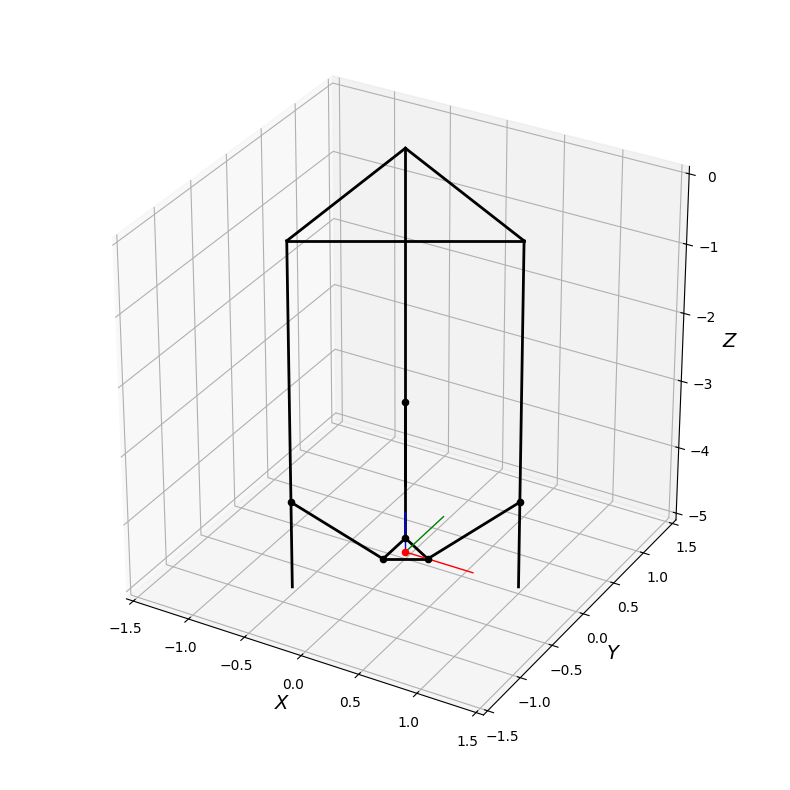

In [12]:
draw_inverse([0, 0, -Lr], draw_tcp_cart=True).show()

<img src="images/pris_x-axis.gif" alt="drawing" width="600"/>
<img src="images/pris_y-axis.gif" alt="drawing" width="600"/>
<br>
<img src="images/pris_z-axis.gif" alt="drawing" width="600"/>
<img src="images/pris_circle.gif" alt="drawing" width="600"/>